In [1]:
import tensorflow as tf
import numpy as np

from pinn import PINNModel, model1
from accuracy import AccuracyCalc
from plotting import NNPlots
from data_gen import DataGenerator

2024-10-11 21:40:57.828025: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-11 21:40:57.841905: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-11 21:40:57.846006: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-11 21:40:57.857484: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-11 21:40:58.643229: W tensorflow/compiler/tf2

In [2]:
def real_u(area):
    area = np.array(area)
    if len(area.shape) >= 3:
        x = area[0]
        y = area[1]
        return np.sin(np.pi * x) * np.sin(np.pi * y)
    else:
        return np.array([np.sin(np.pi * x) * np.sin(np.pi * y)  for x, y in area])

In [3]:
# force gpu use
gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

In [4]:
area_grid_size = (50, 50)
x_limits = (0, 2)
y_limits = (0, 2)
border_grid_size = (50, 50)

EPOCHS = 100000
EPRINT = 500
LOSS = 1e-4

# Define the learning rate schedule
boundaries = [5000, 25000, 50000]
values = [1e-3, 1e-4, 1e-5, 1e-6]

lr_sched = tf.optimizers.schedules.PiecewiseConstantDecay(boundaries, values)

model = PINNModel(model1(4), optm = tf.keras.optimizers.Adam(learning_rate=lr_sched))

dataGen = DataGenerator(x_limits, y_limits, model.predict, real_u)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,353 (17.00 KB)

 Trainable params: 4,353 (17.00 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
model.train(3, dataGen.inner_pairs(area_grid_size), dataGen.border_pairs(border_grid_size), EPOCHS, LOSS, EPRINT)

epoch: 0 loss: 100.810066
epoch: 500 loss: 0.0593274608
epoch: 1000 loss: 0.0202380847
epoch: 1500 loss: 0.00692930212
epoch: 2000 loss: 0.0026993705
epoch: 2500 loss: 0.00184984913
epoch: 3000 loss: 0.00152387843
epoch: 3500 loss: 0.000774805842
epoch: 4000 loss: 0.00185487198
epoch: 4500 loss: 0.00111946242
epoch: 5000 loss: 0.00124803337
epoch: 5500 loss: 0.000218881454
epoch: 6000 loss: 0.000212223662
epoch: 6500 loss: 0.000204717842
epoch: 7000 loss: 0.000195482
epoch: 7500 loss: 0.000188578269
epoch: 8000 loss: 0.000178067479
epoch: 8500 loss: 0.000168062354
epoch: 9000 loss: 0.000158961149
epoch: 9500 loss: 0.000193981876
epoch: 10000 loss: 0.000201328745
epoch: 10500 loss: 0.000153151443
epoch: 11000 loss: 0.00014830842
epoch: 11500 loss: 0.000144530655
epoch: 12000 loss: 0.000115072653
epoch: 12500 loss: 0.000139596334
epoch: 13000 loss: 0.000120396318
epoch: 13500 loss: 0.000113370115
epoch: 14000 loss: 9.5431642e-05


In [6]:
# for k in range(1, 10):
#     # model.reset_weights()
#     model.train(k, dataGen.inner_pairs(area_grid_size), dataGen.border_pairs(border_grid_size), EPOCHS, LOSS, EPRINT)
    
#     print("Error:", acc.mse())
#     print("Error:", acc.maxe())

#     model.save(f"../models/model{k}.weights.h5")

#     break

In [7]:
# Should be created after training model, because of predict in __init__
plotter = NNPlots(dataGen, (200, 200))
acc = AccuracyCalc(dataGen, (70, 70))

I0000 00:00:1728672126.233763   17283 service.cc:146] XLA service 0x7f50f9bc7fc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728672126.233780   17283 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2024-10-11 21:42:06.247358: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


 241/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step

I0000 00:00:1728672126.724648   17283 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 623us/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [8]:
print("Error:", acc.mse())
print("Error:", acc.maxe())

Error: 3.7799983954420284e-06
Error: 0.007768718525767326


/home/arnautov/projectPractice/pinn_puasson/src/plotting.py:77: UserWarning: The following kwargs were not used by contour: 'linestyle'
  real.contour(
/home/arnautov/projectPractice/pinn_puasson/src/plotting.py:98: UserWarning: The following kwargs were not used by contour: 'linestyle'
  pred.contour(
/home/arnautov/projectPractice/pinn_puasson/src/plotting.py:128: UserWarning: The following kwargs were not used by contour: 'linestyle'
  diff.contour(


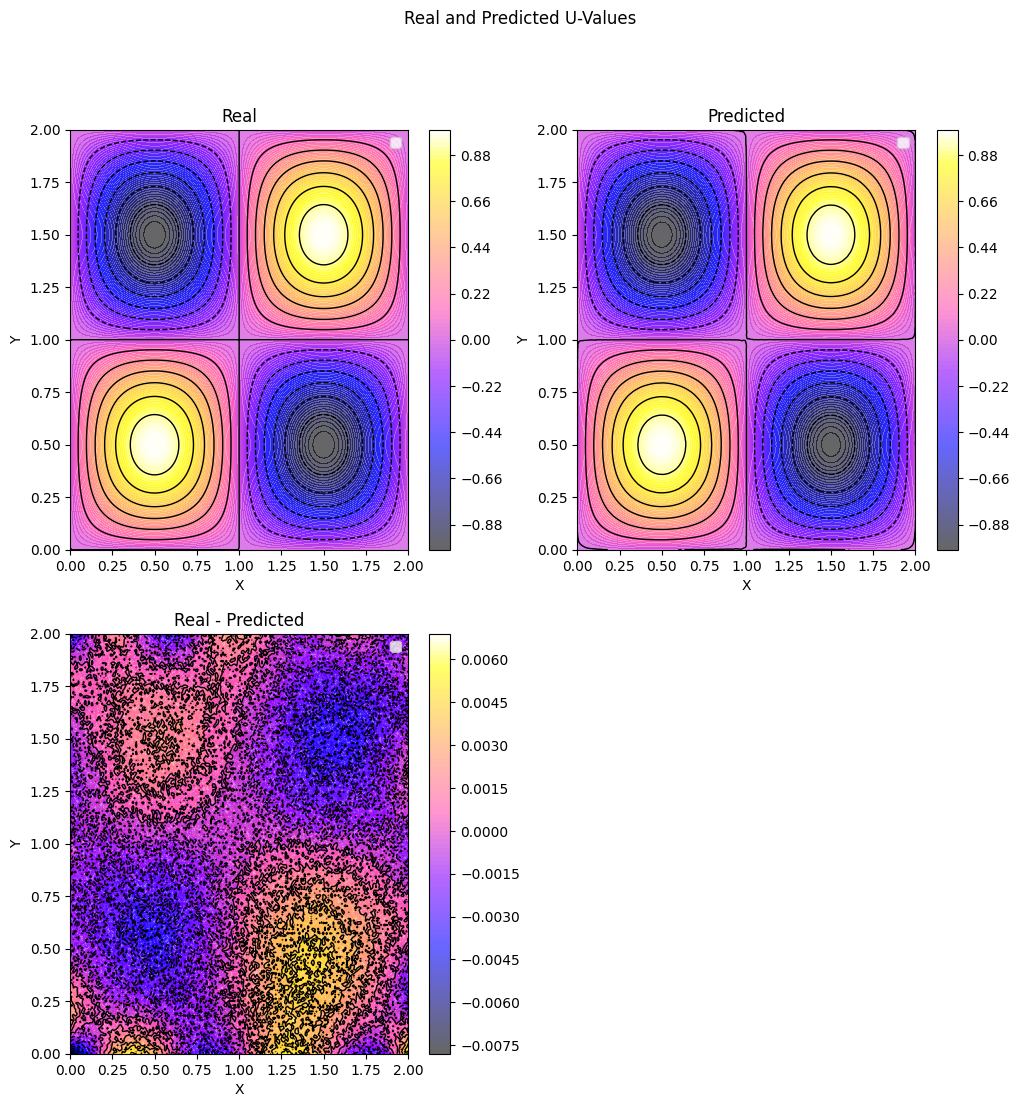

In [9]:
plotter.plot2d_contour(color_map="gnuplot2")